# **Deep Leaning based Segmentation**

### Importing Necessary Libraries

In [1]:
import os
import torch
import json
import zipfile
import random
import gdown
import cv2
import tqdm
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

### Downloading Dataset

In [3]:
def download_dataset():
  dataset_url = "https://drive.google.com/uc?export=download&id=1xrQK9pLB2UiWy0pxdXU-WWbrSZI2A-s4"
  output = "dataset.zip"
  gdown.download(dataset_url, output, quiet=False)

  current_path = os.getcwd()
  with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(current_path)

  return current_path

current_path = download_dataset()

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1xrQK9pLB2UiWy0pxdXU-WWbrSZI2A-s4
From (redirected): https://drive.google.com/uc?export=download&id=1xrQK9pLB2UiWy0pxdXU-WWbrSZI2A-s4&confirm=t&uuid=1d7caf55-901b-47e0-a53d-10275dc1fe84
To: /content/dataset.zip
100%|██████████| 335M/335M [00:08<00:00, 40.8MB/s]


### **Preprocessing Data**

In [4]:
def preprocess():
  train_test_split = json.load(open(current_path + '/dataset/train_test_split.json'))
  label2cmap = json.load(open(current_path + '/dataset/label2cmap.json'))

  labels = list(label2cmap.keys())
  cmap = np.zeros((9, 3)).astype('int')

  for i in range(len(labels)):
    cmap[i] = np.array(label2cmap[labels[i]])
    print(labels[i], cmap[i])

  count = 0
  for name_list in train_test_split.values():
    for name in name_list:
      mask = np.asarray(Image.open(current_path + '/dataset/masks/' + name))
      new_mask = np.zeros((mask.shape[0], mask.shape[1], 1)).astype('int')

      for index in range(len(labels)):
        new_mask[(mask[:,:,0] == cmap[index][0]) & (mask[:,:,1] == cmap[index][1]) & (mask[:,:,2] == cmap[index][2])] = np.array([index]).reshape(1, 1)

      cv2.imwrite(current_path + '/dataset/new_masks/' + name, new_mask)
      count = count + 1

  print("Total", count, "masks preprocessed!")
  return labels, cmap


if not os.path.exists(current_path + '/dataset/new_masks'):
  os.makedirs(current_path + '/dataset/new_masks')
labels, cmap = preprocess()

Background [145  96  65]
Ground [226 213 222]
Bowler [  0  24 253]
Batsmen [176 122  83]
Wicket Keeper [143 223 169]
Umpire [226   9  89]
Fielder [194 254 107]
Ball [ 94 141  56]
Wicket [30 71 42]
Total 298 masks preprocessed!


In [5]:
def load_dataset():
  train_test_split = json.load(open(current_path + '/dataset/train_test_split.json'))

  train_images = []
  train_masks = []
  test_images = []
  test_masks = []

  for name in train_test_split['train']:
    image = np.asarray(Image.open(current_path + '/dataset/images/' + name))
    mask = np.asarray(Image.open(current_path + '/dataset/new_masks/' + name))
    train_images.append(image)
    train_masks.append(mask)

  for name in train_test_split['test']:
    image = np.asarray(Image.open(current_path + '/dataset/images/' + name))
    mask = np.asarray(Image.open(current_path + '/dataset/new_masks/' + name))
    test_images.append(image)
    test_masks.append(mask)

  train_images = np.array(train_images)
  train_masks = np.array(train_masks)
  test_images = np.array(test_images)
  test_masks = np.array(test_masks)

  return train_images, train_masks, test_images, test_masks

train_images, train_masks, test_images, test_masks = load_dataset()

In [6]:
print("Train Images shape =", train_images.shape)
print("Train Masks shape =", train_masks.shape)
print("Test Images shape =", test_images.shape)
print("Test Masks shape =", test_masks.shape)

Train Images shape = (248, 1080, 1920, 3)
Train Masks shape = (248, 1080, 1920)
Test Images shape = (50, 1080, 1920, 3)
Test Masks shape = (50, 1080, 1920)


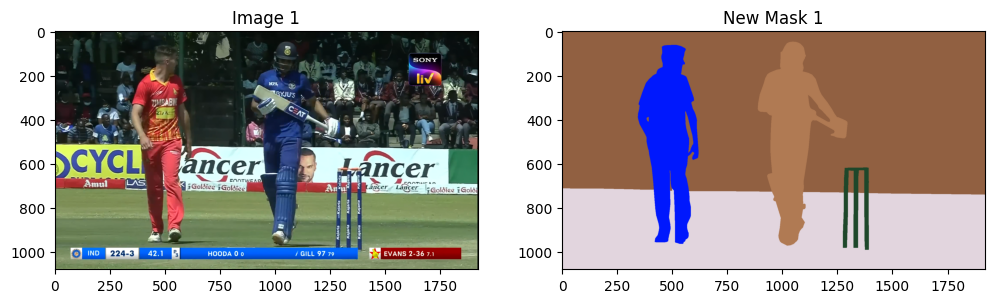

In [19]:
fig, axs = pyplot.subplots(nrows=1, ncols=2, figsize=(12, 4))
pyplot.subplots_adjust(hspace=0.5)
i1 = np.random.randint(248)
m1 = train_masks[i1]

mask1 = np.zeros((m1.shape[0], m1.shape[1], 3)).astype('int')

for index in range(len(labels)):
  mask1[(m1[:,:] == index)] = cmap[index]

axs[0].imshow(train_images[i1])
axs[0].set_title("Image 1")

axs[1].imshow(mask1)
axs[1].set_title("New Mask 1")

pyplot.show()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Downloading Pretrained RESNET18

In [ ]:
from torchvision.models import resnet18
model = resnet18(weights='DEFAULT').to(device)

child_counter = 0
for child in model.children():
   print("Child", child_counter, "is:")
   print(child)
   child_counter += 1

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s]


Child 0 is:
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Child 1 is:
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Child 2 is:
ReLU(inplace=True)
Child 3 is:
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Child 4 is:
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64,

In [ ]:
for param in model.parameters():
    param.requires_grad = False

### Model Summary

In [ ]:
summary(model, (3, 1080, 1920))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 540, 960]           9,408
       BatchNorm2d-2         [-1, 64, 540, 960]             128
              ReLU-3         [-1, 64, 540, 960]               0
         MaxPool2d-4         [-1, 64, 270, 480]               0
            Conv2d-5         [-1, 64, 270, 480]          36,864
       BatchNorm2d-6         [-1, 64, 270, 480]             128
              ReLU-7         [-1, 64, 270, 480]               0
            Conv2d-8         [-1, 64, 270, 480]          36,864
       BatchNorm2d-9         [-1, 64, 270, 480]             128
             ReLU-10         [-1, 64, 270, 480]               0
       BasicBlock-11         [-1, 64, 270, 480]               0
           Conv2d-12         [-1, 64, 270, 480]          36,864
      BatchNorm2d-13         [-1, 64, 270, 480]             128
             ReLU-14         [-1, 64, 2

### **MODEL1: Without Skip Connections**

In [ ]:
class FCNWithoutSkipConnections(nn.Module):
  def __init__(self, pretrained_model, n_class):
    super().__init__()

    self.n_class = n_class
    self.resnet18 = nn.Sequential(*list(pretrained_model.children())[0:8])
    self.relu    = nn.ReLU(inplace=True)

    self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn1     = nn.BatchNorm2d(256)

    self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=(0, 1))
    self.bn2     = nn.BatchNorm2d(128)

    self.deconv3 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn3     = nn.BatchNorm2d(128)

    self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn4     = nn.BatchNorm2d(64)

    self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn5     = nn.BatchNorm2d(32)

    self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

  def forward(self, x):
    output = self.relu(self.resnet18(x))
    x = self.bn1(self.relu(self.deconv1(output)))
    x = self.bn2(self.relu(self.deconv2(x)))
    x = self.bn3(self.relu(self.deconv3(x)))
    x = self.bn4(self.relu(self.deconv4(x)))
    x = self.bn5(self.relu(self.deconv5(x)))
    x = self.classifier(x)
    return x

### **MODEL2: With Skip Connections**

In [ ]:
class FCNWithSkipConnections(nn.Module):
  def __init__(self, pretrained_model, n_class):
    super().__init__()
    self.n_class = n_class
    self.relu    = nn.ReLU(inplace=True)

    self.resnet18_5 = nn.Sequential(*list(pretrained_model.children())[0:6])
    self.resnet18_6 = nn.Sequential(*list(pretrained_model.children())[6])
    self.resnet18_7 = nn.Sequential(*list(pretrained_model.children())[7])

    self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn1     = nn.BatchNorm2d(512)

    self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=(0,1))
    self.bn2     = nn.BatchNorm2d(256)

    self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn3     = nn.BatchNorm2d(128)

    self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn4     = nn.BatchNorm2d(64)

    self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn5     = nn.BatchNorm2d(32)

    self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

  def forward(self, x):
    x5 = self.relu(self.resnet18_5(x))
    x6 = self.relu(self.resnet18_6(x5))
    x7 = self.relu(self.resnet18_7(x6))

    x = self.bn1(self.relu(self.deconv1(x7)))
    x = self.bn2(self.relu(self.deconv2(x + x6)))
    x = self.bn3(self.relu(self.deconv3(x + x5)))
    x = self.bn4(self.relu(self.deconv4(x)))
    x = self.bn5(self.relu(self.deconv5(x)))
    x = self.classifier(x)

    return x

### Evaluation Metric: Mean IOU

In [ ]:
def get_iou(pred, target, n_class=9):
  ious = []
  for cls in range(n_class):
      pred_inds = pred == cls
      target_inds = target == cls
      intersection = pred_inds[target_inds].sum()
      union = pred_inds.sum() + target_inds.sum() - intersection
      if union == 0:
          ious.append(float('nan'))
      else:
          ious.append(float(intersection) / max(union, 1))

  return ious

In [ ]:
train_examples = 224
validation_examples = 24

class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = np.transpose(X, (0, 3, 1, 2))
        self.Y = Y
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.normalize(torch.from_numpy(self.X[index].astype(np.float32) / 255)), self.Y[index])

dataset = CustomDataset(train_images, train_masks)
train_set, validation_set = random_split(dataset, [train_examples, validation_examples])
test_set_1 = CustomDataset(test_images, test_masks)

In [ ]:
test_images = None
test_masks = None
train_images = None
train_masks = None

### Loss and Accuracies

In [ ]:
def plot_losses(history):
  train_losses = []
  validation_losses = []

  for result in history:
    train_losses.append(result["train_loss"])
    validation_losses.append(result["validation_loss"])

  pyplot.plot(train_losses, '-bx')
  pyplot.plot(validation_losses, '-rx')
  pyplot.xlabel('epoch')
  pyplot.ylabel('loss')
  pyplot.legend(['Training', 'Validation'])
  pyplot.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
  train_accuracies = []
  validation_accuracies = []

  for result in history:
    train_accuracies.append(result["train_accuracy"])
    validation_accuracies.append(result["validation_accuracy"])

  pyplot.plot(train_accuracies, '-bx')
  pyplot.plot(validation_accuracies, '-rx')
  pyplot.xlabel('epoch')
  pyplot.ylabel('pixel acurracy')
  pyplot.legend(['Training', 'Validation'])
  pyplot.title('Pixel Acurracy vs. No. of epochs');

In [ ]:
def get_rgb_mask(mask):
  rgb_mask = np.zeros((mask.shape[0], mask.shape[1], 3)).astype('int')

  for index in range(len(labels)):
    rgb_mask[(mask[:,:] == index)] = cmap[index]

  return rgb_mask

In [ ]:
def show_example(true_masks, masks):
  true_masks = true_masks.to('cpu')
  masks = masks.to('cpu')

  fig, axs = pyplot.subplots(nrows=2, ncols=3, figsize=(12, 6))
  pyplot.subplots_adjust(hspace=0.5)

  axs[0][0].imshow(get_rgb_mask(true_masks[0]))
  axs[0][0].set_title("True Mask 0")

  axs[0][1].imshow(get_rgb_mask(true_masks[1]))
  axs[0][1].set_title("True Mask 1")

  axs[0][2].imshow(get_rgb_mask(true_masks[2]))
  axs[0][2].set_title("True Mask 2")

  axs[1][0].imshow(get_rgb_mask(masks[0]))
  axs[1][0].set_title("Prediction 0")

  axs[1][1].imshow(get_rgb_mask(masks[1]))
  axs[1][1].set_title("Prediction 1")

  axs[1][2].imshow(get_rgb_mask(masks[2]))
  axs[1][2].set_title("Prediction 2")

  pyplot.show()

### Helper Function to evaluate Models

In [ ]:
def evaluate(model):
  model.eval()
  testloader = DataLoader(test_set_1, batch_size=5, shuffle=False)
  with torch.no_grad():
    count = 0
    test_correct = 0
    ious = []
    for data in testloader:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      predictions = torch.argmax(outputs.data, dim=1)

      test_correct += (predictions == labels).sum().item()
      iou = get_iou(predictions, labels)
      ious.extend(iou)

      if (count < 5):
        show_example(labels, predictions)
      count = count + 1


    ious = torch.Tensor(ious)
    return test_correct/(50*108*192), np.nanmean(ious.to('cpu'))

### Helper Function to train Models

In [ ]:
def fit(model, optimization_function, loss_function, train_loader, validation_loader, learning_rate, num_epochs):
  torch.cuda.empty_cache()
  history = []
  optimizer = optimization_function(model.parameters(), learning_rate)
  for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    for i, (x_batch, y_batch) in enumerate(train_loader):
      x_batch = x_batch.to(device)
      y_batch = y_batch.long().to(device)

      y_pred = model(x_batch)
      loss = loss_function(y_pred, y_batch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      predictions = torch.argmax(y_pred.data, dim=1) # shape = (b, 1080, 1920) here b is batch_size
      train_correct += (predictions == y_batch).sum().item()

      train_loss += loss.item()

    # Validation Step
    model.eval()
    with torch.no_grad():
      validation_loss = 0.0
      validation_correct = 0
      for j, (x_val, y_val) in enumerate(validation_loader):
        x_val = x_val.to(device)
        y_val = y_val.long().to(device)

        y_pred = model(x_val)
        loss = loss_function(y_pred, y_val)

        predictions = torch.argmax(y_pred.data, dim=1)
        validation_correct += (predictions == y_val).sum().item()

        validation_loss += loss.item()

    print("Epoch", epoch+1, "-\tTraining Loss :", train_loss, ",\tValidation Loss :", validation_loss)
    history.append({"train_loss" : train_loss, "validation_loss" : validation_loss,
                    "train_accuracy" : train_correct/(train_examples*108*192), "validation_accuracy" : validation_correct/(validation_examples*108*192)})

  return history

## **MODEL1: Training**

In [ ]:
model_1 = FCNWithoutSkipConnections(pretrained_model = model, n_class = 9).to(device)
summary(model_1, (3, 1080, 1920))

train_loader = DataLoader(train_set, batch_size=3, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=3, shuffle=False)
optimization_function = torch.optim.Adam
loss_function = F.cross_entropy

history_1 = fit(model_1, optimization_function, loss_function, train_loader, validation_loader, learning_rate=0.0001, num_epochs=30)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 540, 960]           9,408
       BatchNorm2d-2         [-1, 64, 540, 960]             128
              ReLU-3         [-1, 64, 540, 960]               0
         MaxPool2d-4         [-1, 64, 270, 480]               0
            Conv2d-5         [-1, 64, 270, 480]          36,864
       BatchNorm2d-6         [-1, 64, 270, 480]             128
              ReLU-7         [-1, 64, 270, 480]               0
            Conv2d-8         [-1, 64, 270, 480]          36,864
       BatchNorm2d-9         [-1, 64, 270, 480]             128
             ReLU-10         [-1, 64, 270, 480]               0
       BasicBlock-11         [-1, 64, 270, 480]               0
           Conv2d-12         [-1, 64, 270, 480]          36,864
      BatchNorm2d-13         [-1, 64, 270, 480]             128
             ReLU-14         [-1, 64, 2

In [ ]:
torch.save(model_1, '/content/withoutskip.pt')

## **MODEL1: Loss**

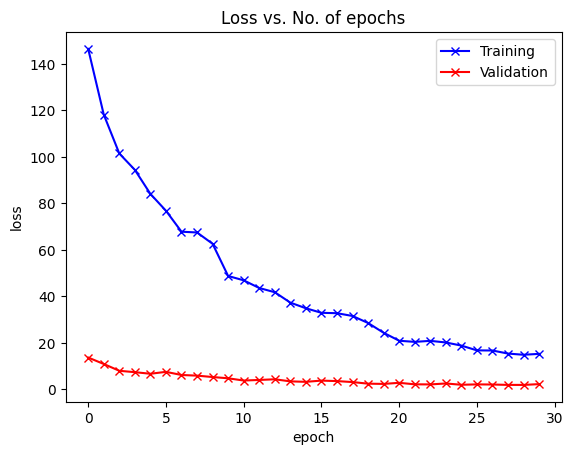

In [ ]:
plot_losses(history_1)

## **MOODEL1: Accuracy**

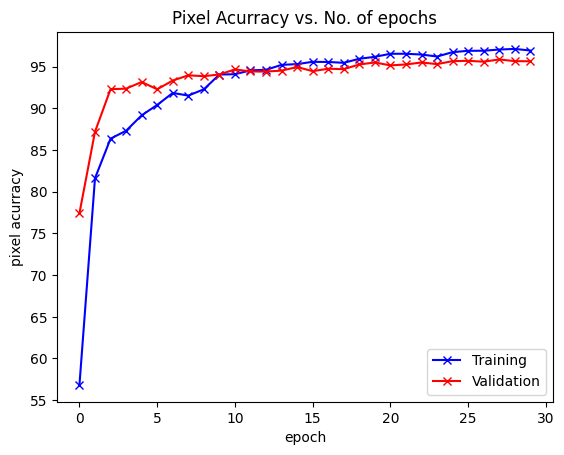

In [ ]:
plot_accuracies(history_1)

## **MODEL1: Predictions**

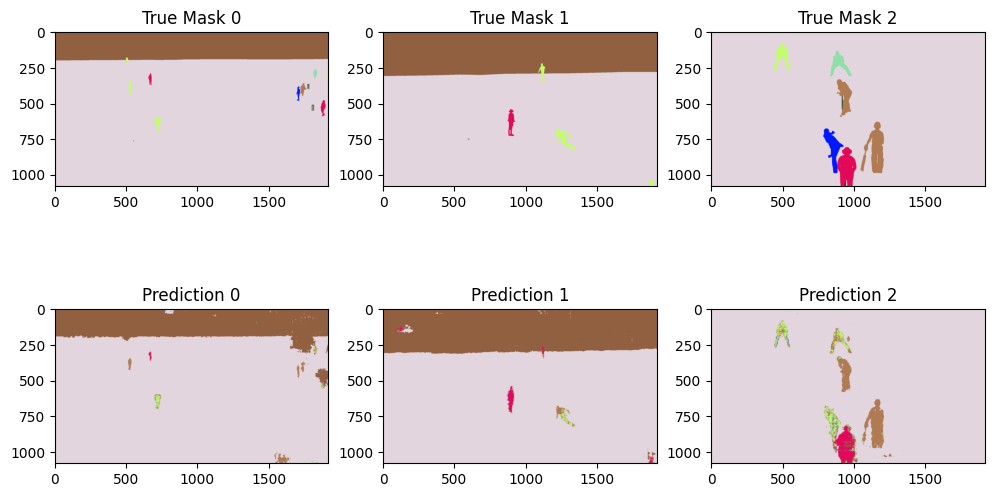

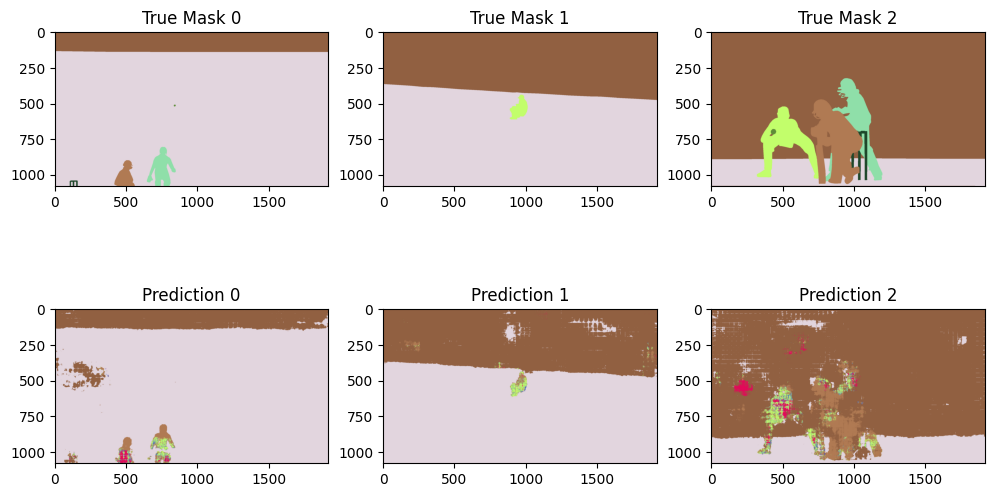

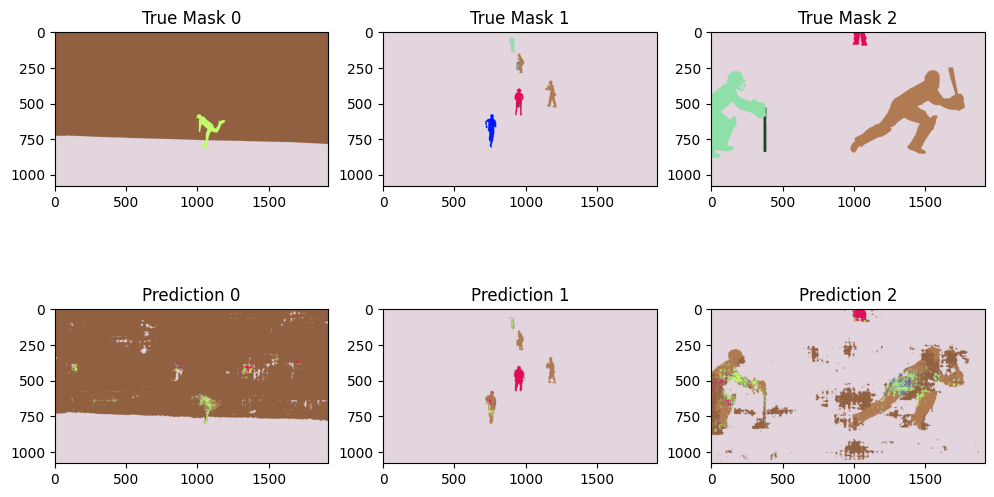

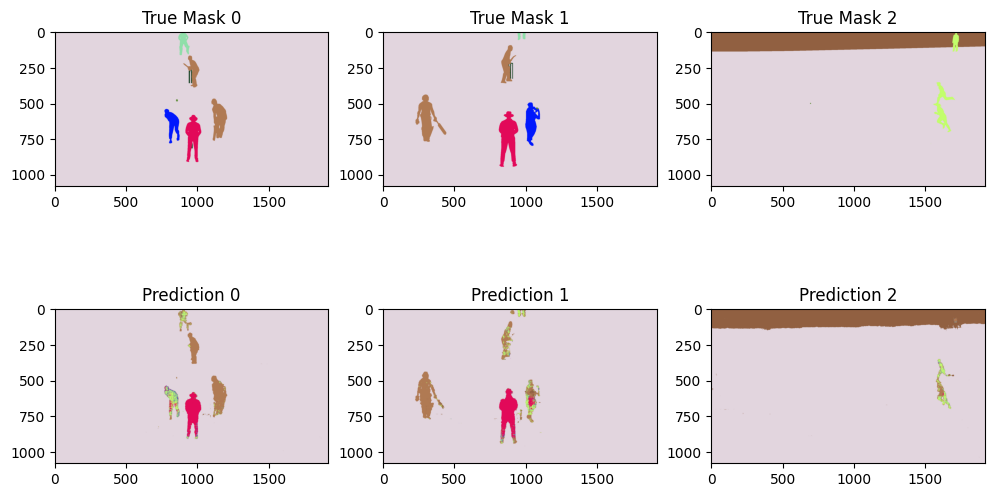

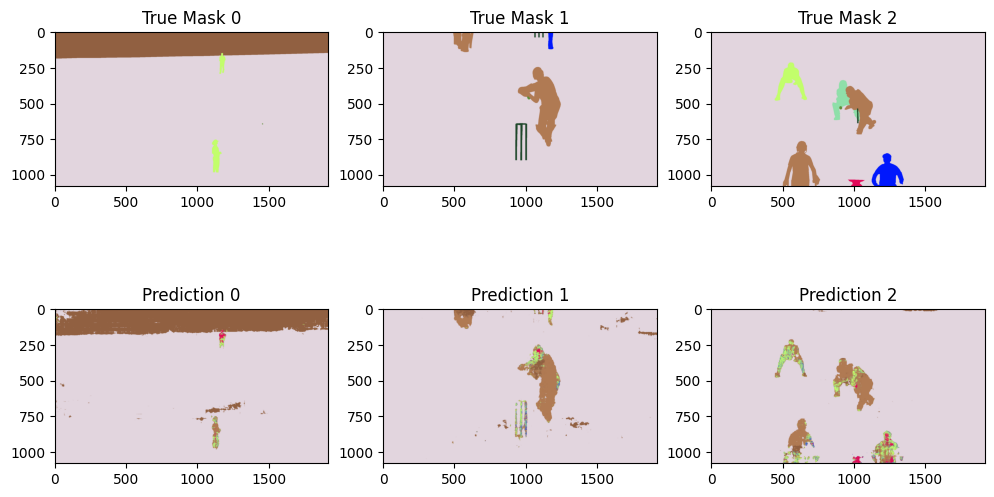

Pixel Accuracy is = 95.86450135030864 /tMean IoU = 0.32179904


In [ ]:
pixel_accuracy, mean_iou = evaluate(model_1)
print("Pixel Accuracy is =", pixel_accuracy, "/tMean IoU =", mean_iou)

In [ ]:
# Freeing memory
del model_1
torch.cuda.empty_cache()

# **MODEL2: Training**

In [ ]:
model_2 = FCNWithSkipConnections(pretrained_model = model, n_class = 9).to(device)
summary(model_2, (3, 1080, 1920))

train_loader = DataLoader(train_set, batch_size=5, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=3, shuffle=False)
optimization_function = torch.optim.Adam
loss_function = F.cross_entropy

history_2 = fit(model_2, optimization_function, loss_function, train_loader, validation_loader, learning_rate=0.0001, num_epochs=30)
torch.save(model_2, '/content/withskip.pt')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 540, 960]           9,408
       BatchNorm2d-2         [-1, 64, 540, 960]             128
              ReLU-3         [-1, 64, 540, 960]               0
         MaxPool2d-4         [-1, 64, 270, 480]               0
            Conv2d-5         [-1, 64, 270, 480]          36,864
       BatchNorm2d-6         [-1, 64, 270, 480]             128
              ReLU-7         [-1, 64, 270, 480]               0
            Conv2d-8         [-1, 64, 270, 480]          36,864
       BatchNorm2d-9         [-1, 64, 270, 480]             128
             ReLU-10         [-1, 64, 270, 480]               0
       BasicBlock-11         [-1, 64, 270, 480]               0
           Conv2d-12         [-1, 64, 270, 480]          36,864
      BatchNorm2d-13         [-1, 64, 270, 480]             128
             ReLU-14         [-1, 64, 2

In [ ]:
torch.save(model_2, '/content/withskip.pt')

In [ ]:
from google.colab import files
files.download('withskip.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **MODEL2: Loss**

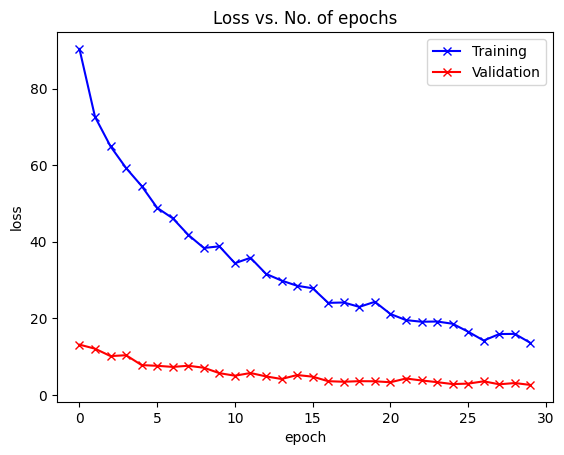

In [ ]:
plot_losses(history_2)

## **MODEL2: Accuracy**

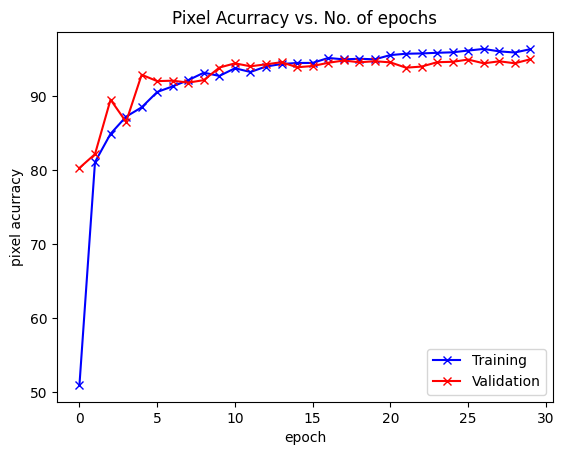

In [ ]:
plot_accuracies(history_2)

## **MODEL2: Predictions**

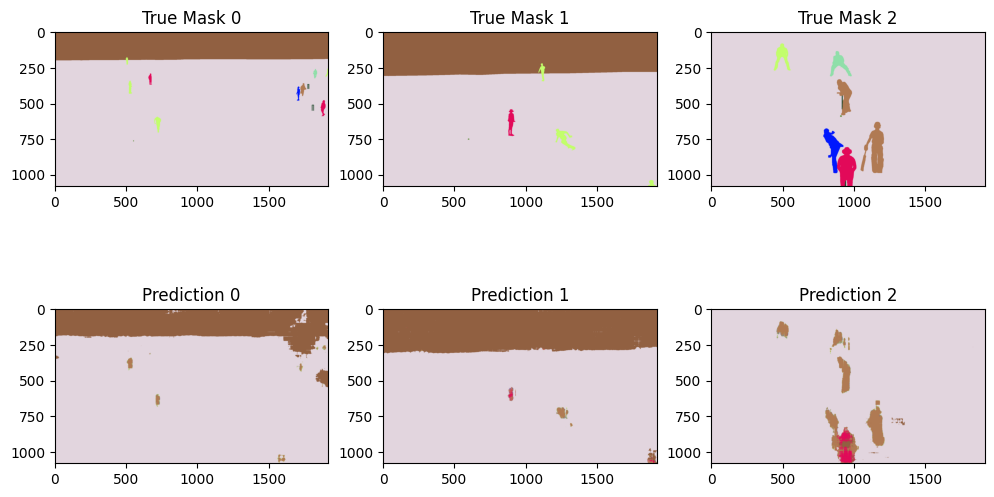

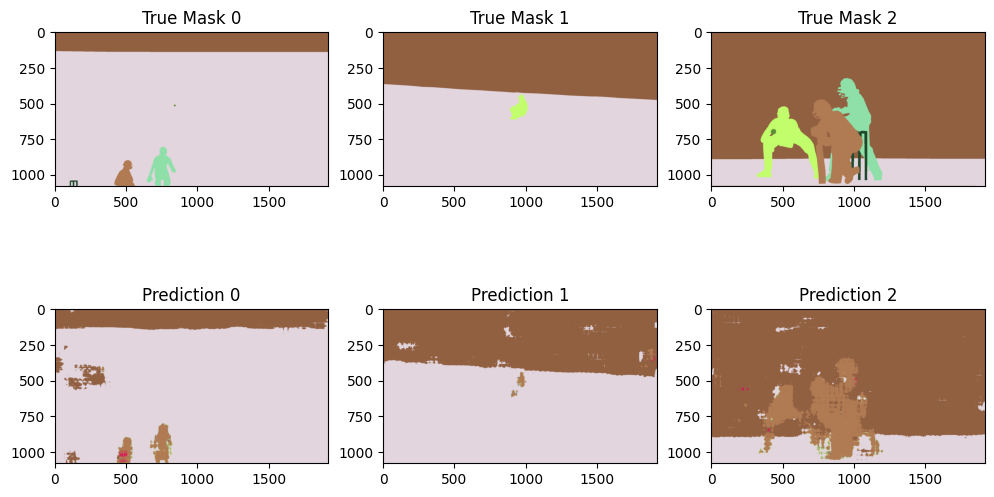

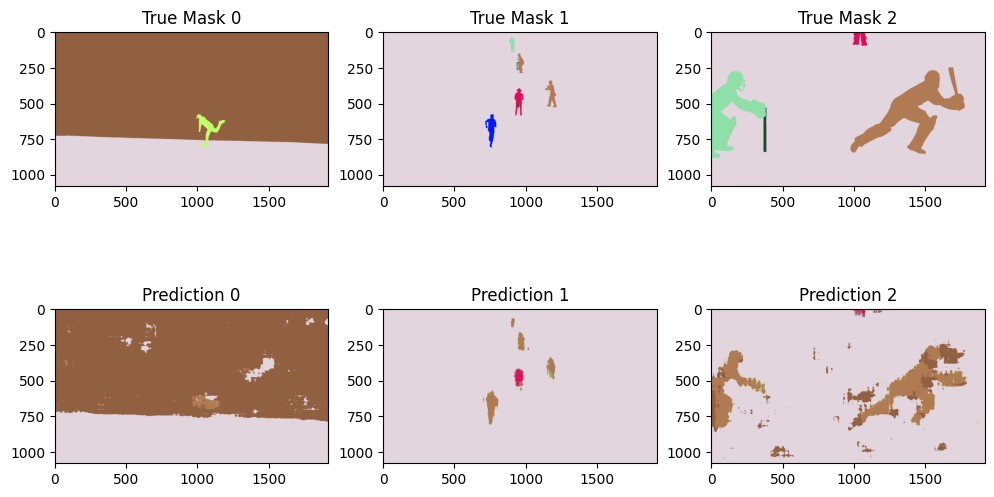

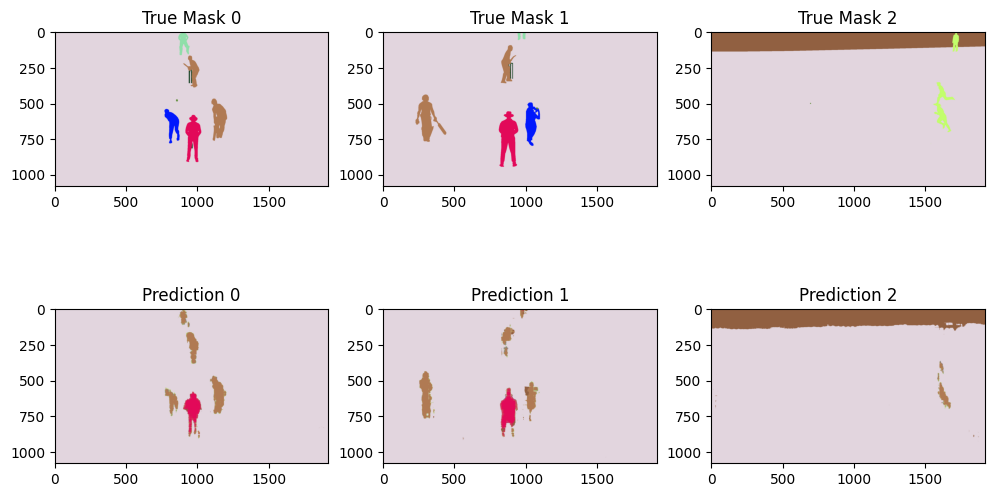

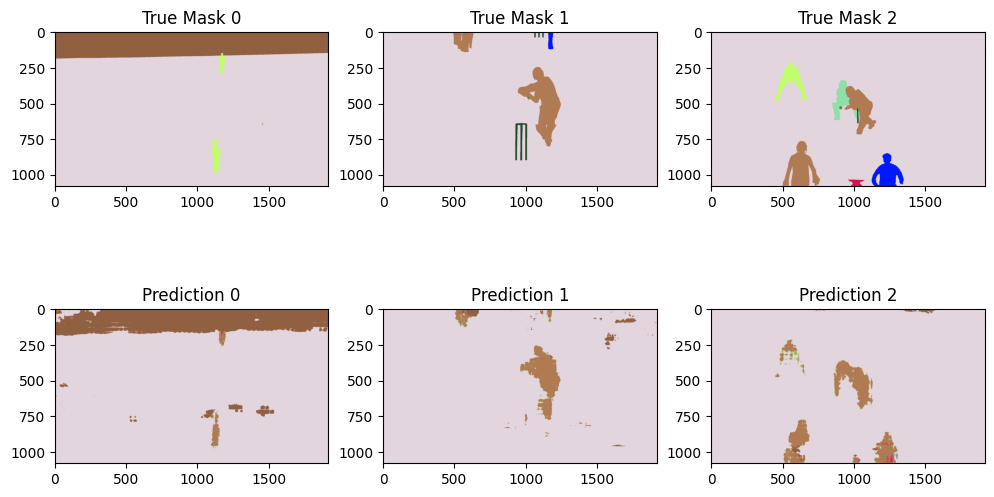

Pixel Accuracy is = 95.3966550925926 /tMean IoU = 0.27563897


In [ ]:
pixel_accuracy, mean_iou = evaluate(model_2)
print("Pixel Accuracy is =", pixel_accuracy, "/tMean IoU =", mean_iou)

# **Evaluation Metric Comparison**

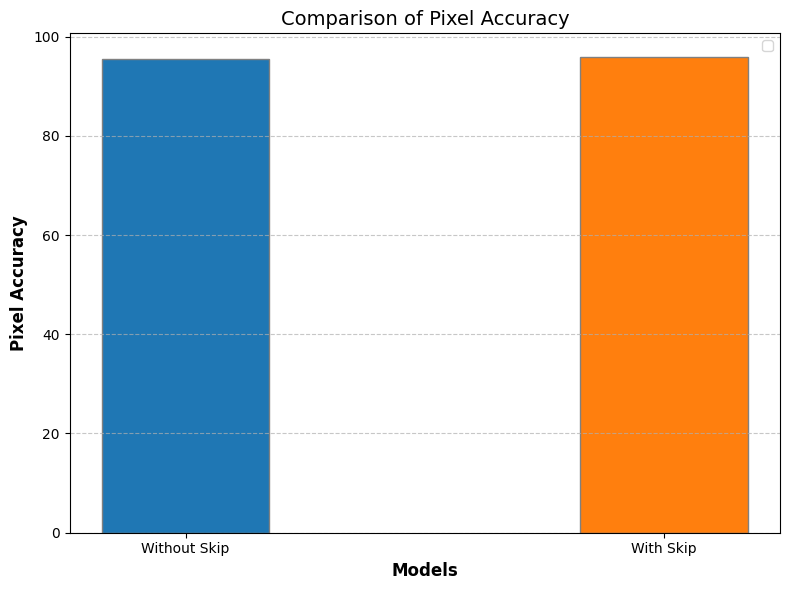

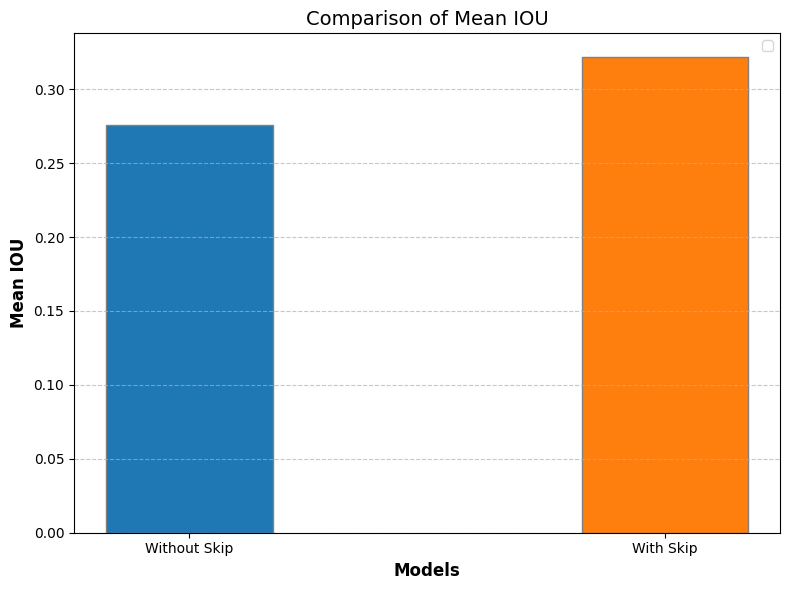

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

models = ['Without Skip', 'With Skip']
pixel_accuracy = [95.39, 95.86]
mean_iou = [0.2756, 0.3217]
bar_width = 0.35
r1 = np.arange(len(models))
plt.figure(figsize=(8, 6))
plt.bar(r1, pixel_accuracy, color=['#1f77b4', '#ff7f0e'], width=bar_width, edgecolor='grey')
plt.xlabel('Models', fontweight='bold', fontsize=12)
plt.ylabel('Pixel Accuracy', fontweight='bold', fontsize=12)
plt.xticks(r1, models, fontsize=10)
plt.title('Comparison of Pixel Accuracy', fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(r1, mean_iou, color=['#1f77b4', '#ff7f0e'], width=bar_width, edgecolor='grey')
plt.xlabel('Models', fontweight='bold', fontsize=12)
plt.ylabel('Mean IOU', fontweight='bold', fontsize=12)
plt.xticks(r1, models, fontsize=10)
plt.title('Comparison of Mean IOU', fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
